## Imports

In [57]:
import ipywidgets as widgets
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy

from librosa.core.spectrum import power_to_db, _spectrogram
from librosa.core.convert import fft_frequencies, mel_frequencies

## Functions

In [63]:
def mel(sr, n_fft):

    fmin=0.0
    n_mels=128
    fmax = float(sr) / 2

    n_mels = int(n_mels)
    weights = np.zeros((n_mels, int(1 + n_fft // 2)), dtype=np.float32)

    fftfreqs = fft_frequencies(sr=sr, n_fft=n_fft)

    mel_f = mel_frequencies(n_mels + 2, fmin=fmin, fmax=fmax, htk=False)

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]

        weights[i] = np.maximum(0, np.minimum(lower, upper))


    enorm = 2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])
    weights *= enorm[:, np.newaxis]
   
    return weights

In [86]:
def melspectrogram(y, sr):

    S, n_fft = _spectrogram(
        y=y,
        S=None,
        n_fft=2048,
        hop_length=512,
        power=2.0,
        win_length=None,
        window="hann",
        center=True,
        pad_mode="constant",
    )

    mel_basis = mel(sr=sr, n_fft=n_fft)

    return np.einsum("...ft,mf->...mt", S, mel_basis, optimize=True)

In [92]:
def mfcc(y, sr):

    S = power_to_db(melspectrogram(y=y, sr=sr))

    return scipy.fftpack.dct(S, axis=-2, type=2, norm="ortho")[..., :20, :]


## Use cases

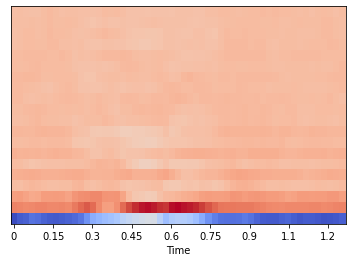

In [95]:
mfccs = mfcc(y=x, sr=sr)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')